In [1]:
from __future__ import print_function
import os
import pickle

import numpy as np
import time
import datetime

from sklearn import svm, datasets
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import scipy.io
import scipy.integrate
from astropy.convolution import convolve, Box1DKernel

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.path import Path as mpath
from scipy.optimize import least_squares

import pandas as pd
from pathlib import Path

%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 90

np.set_printoptions(threshold=np.nan)

plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)

###############
## COMPUTER ##
###############

laptop = False

In [2]:
def boxcar_width(x):
    return (np.ceil(x) // 2 * 2 + 1).astype(int)

In [3]:
###############
## CONSTANTS ##
###############

nu =  1.488*10**(-5) #m^2/s kinematic viscosity of air at 18 deg celcius
rho = 1.212          #kg/m^3 density of air at 18 deg celcius & 1 atm
p_ref = 1000.0       #mbar refence pressure for potential temp
g = 9.81             #m/s^2 gravity
Rd = 287             #J/kg/K specific gas constant of dry air
gamma = -0.0065      #K/m dry air lapse rate
z0 = 1213            #m elevation at deployment
cp = 1006            #J/kg/K specific heat of dry air at 18 deg celcius & 1 atm
kap = 0.38           #ND von karman's constant

In [4]:
############
## SENSIT ##
############

if laptop==True:
    %cd /home/andle/Documents/Python/met2_sensit18/
else:
    %cd /home/andrew/Documents/Python/met2_sensit18/

startindex = 0
endindex   = -1

temp_path = Path("sensit.CSV")
tempdata = pd.read_csv(temp_path,delimiter=',',header=0)

CN_s = np.asarray(tempdata.iloc[startindex:endindex,2])/10
KE_s = np.asarray(tempdata.iloc[startindex:endindex,3])/10

t_s_temp = np.asarray(tempdata.iloc[startindex:endindex,0]) #in datetime format so temp
t_s = []

for i in range(0,len(t_s_temp)):
    t_s.append(int(time.mktime(datetime.datetime.strptime(str(tempdata.iloc[i,0]),'%Y-%m-%d %H:%M:%S').timetuple())))
t_s = np.asarray(t_s)

/home/andrew/Documents/Python/met2_sensit18


In [5]:
############
## WHSA2  ##
############

if laptop==True:
    %cd /home/andle/Documents/Python/met2_sensit18/
else:
    %cd /home/andrew/Documents/Python/met2_sensit18/

startindex = 0
endindex   = -1

temp_path = Path('CR1000_Avg10Min.CSV')
tempdata = pd.read_csv(temp_path,delimiter=',',header=0)

z_T = 10 #height of T,Td,p,psl,h

z_m = [2,5]

T_m   = np.asarray(tempdata.iloc[startindex:endindex,16]) #temp celcius
Td_m  = np.asarray(tempdata.iloc[startindex:endindex,18]) #dew point celcius
p_m   = np.asarray(tempdata.iloc[startindex:endindex,19]) #local pressure mbar
h_m   = np.asarray(tempdata.iloc[startindex:endindex,17]) #relative humidity in %

u0_m = np.asarray(tempdata.iloc[startindex:endindex,12])
u1_m = np.asarray(tempdata.iloc[startindex:endindex,8])

t_m_temp = np.asarray(tempdata.iloc[startindex:endindex,0]) #in datetime format so temp
t_m = []

for i in range(0,len(t_m_temp)):
    t_m.append(int(time.mktime(datetime.datetime.strptime(str(tempdata.iloc[i,0]),'%Y-%m-%d %H:%M:%S').timetuple())))
t_m = np.asarray(t_m)

/home/andrew/Documents/Python/met2_sensit18


In [6]:
############
## CUPS   ##
############

if laptop==True:
    %cd /home/andle/Documents/Python/cuparray18/useful/
else:
    %cd /home/andrew/Documents/Python/cuparray18/useful/

t_c  = []
n0_c = []
n1_c = []
n2_c = []
n3_c = []

Ti_c = []
Tf_c = []

z_c = np.asarray([0.32,0.76,1.14,1.68])

delta_t_c = 1.0153443553858519

l = os.listdir()
l = np.sort(l)
for i in l:
    if i.endswith('.CSV'):

        temp_path = Path(i)
        tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
        
        ti_c = int(time.mktime(datetime.datetime.strptime(str(tempdata.iloc[0,0]),'%m/%d/%Y/ %H:%M:%S').timetuple()))
        N3_c = np.asarray(tempdata.iloc[1:,0])
        N2_c = np.asarray(tempdata.iloc[1:,1])
        N1_c = np.asarray(tempdata.iloc[1:,2])
        N0_c = np.asarray(tempdata.iloc[1:,3])
        T_c  = np.linspace(ti_c,ti_c+delta_t_c*np.shape(N0_c)[0],num=np.shape(N0_c)[0])
        
        t_c  = np.append(t_c,T_c)
        n0_c = np.append(n0_c,N0_c)
        n1_c = np.append(n1_c,N1_c)
        n2_c = np.append(n2_c,N2_c)
        n3_c = np.append(n3_c,N3_c)
        
        Ti_c = np.append(Ti_c,ti_c)
        Tf_c = np.append(Tf_c,T_c[-1])
        
n0_c = n0_c.astype('float')
n1_c = n1_c.astype('float')
n2_c = n2_c.astype('float')
n3_c = n3_c.astype('float')

Tii_c = np.where(np.isin(t_c,Ti_c))
Tif_c = np.where(np.isin(t_c,Tf_c))

# FROM KEATON CALIBRATION
# blue correction: y=0.5717x+1.1766           R^2 = of 0.9999
# red correction: y=0.5949x+1.1912           R^2 = of 0.9999
# yellow correction: y=0.5669x+1.0703           R^2 = of 0.9999
# green correction: y = 0.84x + 4.04           R^2 = of 0.7

# where: 
#      x = data logged by cups [volts]
#      y = corrected windspeed [m/s]
    
# Red = anemometer1 = 1.68m
# yellow = anemometer2 = 0.76m
# green = anemometer3 =  1.14m
# blue = anemometer4 = 0.32m

u0_c = 0.5717*n0_c+1.1766
u1_c = 0.5669*n1_c+1.0703
u2_c = 0.8400*n2_c+4.0400
u3_c = 0.5949*n3_c+1.1912

u0_c[n0_c==0] = 0
u1_c[n1_c==0] = 0
u2_c[n2_c==0] = 0
u3_c[n3_c==0] = 0

/home/andrew/Documents/Python/cuparray18/useful


/home/andrew/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
############
## LIDAR  ##
############

if laptop==True:
    %cd /home/andle/Documents/Python/lidar18/csvs/
else:
    %cd /home/andrew/Documents/Python/lidar18/csvs/

# to read files
months = range(1,12+1)
days   = range(1,31+1)
part   = range(1,3)

z_l = np.asarray([1.26,10,14,20,28,38,55,78,109,153,214,300])

t_l = [] # icol 2  timestamp [s]
d_l = [] #icol 1 DD/MM/YYYY HH:MM:SS

T_l = [] # icol 13 temperature [celcius]
p_l = [] # icol 14 pressure [mbar]
h_l = [] # icol 15 humidity [%]

gps_l = []

u0_l = [] 
u1_l = []
u2_l = []
u3_l = []
u4_l = []
u5_l = []
u6_l = []
u7_l = []
u8_l = []
u9_l = []
u10_l = []
u11_l = []

w1_l = []
w2_l = []
w3_l = []
w4_l = []
w5_l = []
w6_l = []
w7_l = []
w8_l = []
w9_l = []
w10_l = []
w11_l = []

for i in months:
    for j in days:
        temp_path = Path("Wind_320@Y2018_M%02d_D%02d.CSV" % (i,j))
        if temp_path.is_file():
            tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
            
            t_l.extend(tempdata.iloc[:,2])
            d_l.extend(pd.to_datetime(tempdata.iloc[:,1]) - pd.Timedelta(hours=2)) #correct timezone from indiana to alamogordo
    
            T_l.extend(tempdata.iloc[:,13])
            p_l.extend(tempdata.iloc[:,14])
            h_l.extend(tempdata.iloc[:,15])
            
            gps_l.extend(tempdata.iloc[:,10])
            
            u11_l.extend(tempdata.iloc[:,20])
            u10_l.extend(tempdata.iloc[:,23])
            u9_l.extend(tempdata.iloc[:,26])
            u8_l.extend(tempdata.iloc[:,29])
            u7_l.extend(tempdata.iloc[:,32])
            u6_l.extend(tempdata.iloc[:,35])
            u5_l.extend(tempdata.iloc[:,38])
            u4_l.extend(tempdata.iloc[:,41])
            u3_l.extend(tempdata.iloc[:,44])
            u2_l.extend(tempdata.iloc[:,47])
            u1_l.extend(tempdata.iloc[:,50])
            u0_l.extend(tempdata.iloc[:,16])
            
            w11_l.extend(tempdata.iloc[:,21])
            w10_l.extend(tempdata.iloc[:,24])
            w9_l.extend(tempdata.iloc[:,27])
            w8_l.extend(tempdata.iloc[:,30])
            w7_l.extend(tempdata.iloc[:,33])
            w6_l.extend(tempdata.iloc[:,36])
            w5_l.extend(tempdata.iloc[:,39])
            w4_l.extend(tempdata.iloc[:,42])
            w3_l.extend(tempdata.iloc[:,45])
            w2_l.extend(tempdata.iloc[:,48])
            w1_l.extend(tempdata.iloc[:,51])
            
        for k in part:
            temp_path = Path("Wind_320@Y2018_M%02d_D%02d-%d.CSV" % (i,j,k))
            if temp_path.is_file():
                tempdata = pd.read_csv(temp_path,delimiter=',',header=1)
                
                t_l.extend(tempdata.iloc[:,2])
                d_l.extend(pd.to_datetime(tempdata.iloc[:,1]) - pd.Timedelta(hours=2)) #correct timezone from indiana to alamogordo

                T_l.extend(tempdata.iloc[:,13])
                p_l.extend(tempdata.iloc[:,14])
                h_l.extend(tempdata.iloc[:,15])
            
                gps_l.extend(tempdata.iloc[:,10])

                u11_l.extend(tempdata.iloc[:,20])
                u10_l.extend(tempdata.iloc[:,23])
                u9_l.extend(tempdata.iloc[:,26])
                u8_l.extend(tempdata.iloc[:,29])
                u7_l.extend(tempdata.iloc[:,32])
                u6_l.extend(tempdata.iloc[:,35])
                u5_l.extend(tempdata.iloc[:,38])
                u4_l.extend(tempdata.iloc[:,41])
                u3_l.extend(tempdata.iloc[:,44])
                u2_l.extend(tempdata.iloc[:,47])
                u1_l.extend(tempdata.iloc[:,50])
                u0_l.extend(tempdata.iloc[:,16])
                
                w11_l.extend(tempdata.iloc[:,21])
                w10_l.extend(tempdata.iloc[:,24])
                w9_l.extend(tempdata.iloc[:,27])
                w8_l.extend(tempdata.iloc[:,30])
                w7_l.extend(tempdata.iloc[:,33])
                w6_l.extend(tempdata.iloc[:,36])
                w5_l.extend(tempdata.iloc[:,39])
                w4_l.extend(tempdata.iloc[:,42])
                w3_l.extend(tempdata.iloc[:,45])
                w2_l.extend(tempdata.iloc[:,48])
                w1_l.extend(tempdata.iloc[:,51])



t_l = np.asarray(t_l)

T_l = np.asarray(T_l)
p_l = np.asarray(p_l) 
h_l = np.asarray(h_l) 

gps_l = np.asarray(gps_l)

u0_l = np.asarray(u0_l)
u1_l = np.asarray(u1_l)
u2_l = np.asarray(u2_l)
u3_l = np.asarray(u3_l)
u4_l = np.asarray(u4_l)
u5_l = np.asarray(u5_l)
u6_l = np.asarray(u6_l)
u7_l = np.asarray(u7_l)
u8_l = np.asarray(u8_l)
u9_l = np.asarray(u9_l)
u10_l = np.asarray(u10_l)
u11_l = np.asarray(u11_l)

w1_l = np.asarray(w1_l)
w2_l = np.asarray(w2_l)
w3_l = np.asarray(w3_l)
w4_l = np.asarray(w4_l)
w5_l = np.asarray(w5_l)
w6_l = np.asarray(w6_l)
w7_l = np.asarray(w7_l)
w8_l = np.asarray(w8_l)
w9_l = np.asarray(w9_l)
w10_l = np.asarray(w10_l)
w11_l = np.asarray(w11_l)

#####

bad_index = np.append(np.argwhere(u0_l==9999.0),np.argwhere(gps_l=='#N/A #N/A'))

bad_index = np.append(bad_index,np.argwhere(u1_l==9999.0))
bad_index = np.append(bad_index,np.argwhere(u2_l==9999.0))
bad_index = np.append(bad_index,np.argwhere(u3_l==9999.0))
bad_index = np.append(bad_index,np.argwhere(u4_l==9999.0))
bad_index = np.append(bad_index,np.argwhere(u5_l==9999.0))
bad_index = np.append(bad_index,np.argwhere(u6_l==9999.0))
bad_index = np.append(bad_index,np.argwhere(u7_l==9999.0))
bad_index = np.append(bad_index,np.argwhere(u8_l==9999.0))
bad_index = np.append(bad_index,np.argwhere(u9_l==9999.0))
bad_index = np.append(bad_index,np.argwhere(u10_l==9999.0))
bad_index = np.append(bad_index,np.argwhere(u11_l==9999.0))

bad_index = np.append(bad_index,np.argwhere(np.isnan(u0_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u1_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u2_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u3_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u4_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u5_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u6_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u7_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u8_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u9_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u10_l)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(u11_l)))

t_l = np.delete(t_l,bad_index)
d_l = np.delete(d_l,bad_index)

T_l = np.delete(T_l,bad_index)
p_l = np.delete(p_l,bad_index)
h_l = np.delete(h_l,bad_index)

u0_l = np.delete(u0_l,bad_index)
u1_l = np.delete(u1_l,bad_index)
u2_l = np.delete(u2_l,bad_index)
u3_l = np.delete(u3_l,bad_index)
u4_l = np.delete(u4_l,bad_index)
u5_l = np.delete(u5_l,bad_index)
u6_l = np.delete(u6_l,bad_index)
u7_l = np.delete(u7_l,bad_index)
u8_l = np.delete(u8_l,bad_index)
u9_l = np.delete(u9_l,bad_index)
u10_l = np.delete(u10_l,bad_index)
u11_l = np.delete(u11_l,bad_index)

u_l = np.asarray([u0_l,u1_l,u2_l,u3_l,u4_l,u5_l,u6_l,u7_l,u8_l,u9_l,u10_l,u11_l])

w1_l = np.delete(w1_l,bad_index)
w2_l = np.delete(w2_l,bad_index)
w3_l = np.delete(w3_l,bad_index)
w4_l = np.delete(w4_l,bad_index)
w5_l = np.delete(w5_l,bad_index)
w6_l = np.delete(w6_l,bad_index)
w7_l = np.delete(w7_l,bad_index)
w8_l = np.delete(w8_l,bad_index)
w9_l = np.delete(w9_l,bad_index)
w10_l = np.delete(w10_l,bad_index)
w11_l = np.delete(w11_l,bad_index)

w_l = np.asarray([w1_l,w2_l,w3_l,w4_l,w5_l,w6_l,w7_l,w8_l,w9_l,w10_l,w11_l])

/home/andrew/Documents/Python/lidar18/csvs


In [8]:
############
## GOES   ##
############

%cd /media/synology2/WANDS/GOES18/clouds/

with open('TIMEKEY.pkl', 'rb') as f:
    TIMEKEY18 = pickle.load(f)
    
with open('NAMEKEY.pkl', 'rb') as f:
    NAMEKEY18 = pickle.load(f)

with open('LATWS.pkl', 'rb') as f:
    LATWS18 = pickle.load(f)
    
with open('LONWS.pkl', 'rb') as f:
    LONWS18 = pickle.load(f)
    
tupVerts=[(-106.40, 32.80), (-106.30, 32.80), (-106.30,32.90), (-106.35, 33.00), (-106.45, 32.95)]

points18 = np.vstack((LONWS18,LATWS18)).T 
p = mpath(tupVerts)
grid18 = p.contains_points(points18)
wspoints18 = np.argwhere(grid18)

#load data

bandsplaya18 = []
timesplaya18 = []

for fn in np.arange(0,10):
    with open('BANDSWS%d.pkl'%fn, 'rb') as f:
        bands = pickle.load(f)

    with open('TIMESWS%d.pkl'%fn, 'rb') as f:
        times = pickle.load(f)
        
    bandsplaya18.append(bands[:,wspoints18,:])
    timesplaya18.append(times)   
        
bandsplaya18 = np.squeeze(np.concatenate(bandsplaya18))
timesplaya18 = np.squeeze(np.concatenate(timesplaya18))

#delete spurious data
bandsplaya18 = np.delete(bandsplaya18,np.argwhere(timesplaya18<1.5214*10**9-6*60*60),axis=0)
timesplaya18 = np.delete(timesplaya18,np.argwhere(timesplaya18<1.5214*10**9-6*60*60))

bandsplaya18 = np.delete(bandsplaya18,np.argwhere(timesplaya18>1.5238*10**9),axis=0)
timesplaya18 = np.delete(timesplaya18,np.argwhere(timesplaya18>1.5238*10**9))

timesplaya18 = np.delete(timesplaya18,np.argwhere(bandsplaya18[:,:,6:]<200))
bandsplaya18 = np.delete(bandsplaya18,np.argwhere(bandsplaya18[:,:,6:]<200),axis=0)

timesplaya18 = np.delete(timesplaya18,np.argwhere(bandsplaya18[:,:,:6]<0))
bandsplaya18 = np.delete(bandsplaya18,np.argwhere(bandsplaya18[:,:,:6]<0),axis=0)

/media/synology2/WANDS/GOES18/clouds


In [9]:
############
## TIMING ##
############

# set all t in seconds starting from 19/03/2018 00:00:00 (cup time is correct)

t_initial = int(time.mktime(datetime.datetime.strptime('2018-03-19 00:00:00','%Y-%m-%d %H:%M:%S').timetuple()))

s_2_d = 1/(60*60*24)

print(t_s[0],t_m[0],t_c[0],t_l[0])

# t_m = t_c-(-60*60*2+60*39+28)-100-4450
# t_m = t_l-588167510+1521488980-29*60*60-18*60-27+1000
# t_m = t_s

dt_1 = 282
dt_2 = 933216963

ts_c = t_c - t_initial
ts_m = t_m - dt_1 - t_initial 
ts_s = t_s - dt_1 - t_initial
ts_l = t_l + dt_2 - dt_1 - t_initial
ts_g = timesplaya18 - t_initial

td_c = ts_c*s_2_d
td_m = ts_m*s_2_d
td_s = ts_s*s_2_d
td_l = ts_l*s_2_d
td_g = ts_g*s_2_d

Tis_c = Ti_c - t_initial
Tid_c = Tis_c*s_2_d

Tfs_c = Tf_c - t_initial
Tfd_c = Tfs_c*s_2_d

tdel_ts_s = ts_s[1]-ts_s[0] #10 seconds
tdel_ts_m = ts_m[1]-ts_m[0] #10 mins, 600 seconds
tdel_ts_c = delta_t_c #just over 1 sec
tdel_ts_g = ts_g[1]-ts_g[0] #5 min

1521486360 1521487200 1521488968.0 588357291.0


In [10]:
############
## ML 2018 ##
############

#uninterrupted time periods where there is only clear or cloud on entire image, 
#or clear sky dust emission on the playa

clear1i_18 = TIMEKEY18[NAMEKEY18==79026] #2033 19mar #0
clear1f_18 = TIMEKEY18[NAMEKEY18==79181] #1208 20mar
clear2i_18 = TIMEKEY18[NAMEKEY18==104110] #0503 14apr #9
clear2f_18 = TIMEKEY18[NAMEKEY18==1042311] #1758 14apr

cloud1i_18 = TIMEKEY18[NAMEKEY18==85130] #0703 26mar #2
cloud1f_18 = TIMEKEY18[NAMEKEY18==860011] #1858 26mar
cloud2i_18 = TIMEKEY18[NAMEKEY18==97130] #0703 7apr #7
cloud2f_18 = TIMEKEY18[NAMEKEY18==97215] #1528 7apr 

dusty1i_18 = TIMEKEY18[NAMEKEY18==92210] #1503 2apr #5
dusty1f_18 = TIMEKEY18[NAMEKEY18==93004] #1823 2apr
dusty2i_18 = TIMEKEY18[NAMEKEY18==102162] #1013 12apr #9
dusty2f_18 = TIMEKEY18[NAMEKEY18==1022011] #1458 12apr

clearlabel = 0
cloudlabel = 1
dustylabel = 2

bandset1 = np.asarray([6,10,12,13])

clear_18 = []
cloud_18 = []
dusty_18 = []

temp = bandsplaya18[(timesplaya18>=clear1i_18)&(timesplaya18<=clear1f_18)]
clear_18.append(temp[:,:,bandset1])
temp = bandsplaya18[(timesplaya18>=clear2i_18)&(timesplaya18<=clear2f_18)]
clear_18.append(temp[:,:,bandset1])
clear_18 = np.concatenate(clear_18)
clear_18 = np.concatenate(clear_18,axis=0)

temp = bandsplaya18[(timesplaya18>=cloud1i_18)&(timesplaya18<=cloud1f_18)]
cloud_18.append(temp[:,:,bandset1])
temp = bandsplaya18[(timesplaya18>=cloud2i_18)&(timesplaya18<=cloud2f_18)]
cloud_18.append(temp[:,:,bandset1])
cloud_18 = np.concatenate(cloud_18)
cloud_18 = np.concatenate(cloud_18,axis=0)

temp = bandsplaya18[(timesplaya18>=dusty1i_18)&(timesplaya18<=dusty1f_18)]
dusty_18.append(temp[:,:,bandset1])
temp = bandsplaya18[(timesplaya18>=dusty2i_18)&(timesplaya18<=dusty2f_18)]
dusty_18.append(temp[:,:,bandset1])
dusty_18 = np.concatenate(dusty_18)
dusty_18 = np.concatenate(dusty_18,axis=0)

featrs18 = [clear_18,cloud_18,dusty_18]
featrs18 = np.concatenate(featrs18)

clearlabelN18 = np.squeeze(clearlabel*np.ones([np.shape(clear_18)[0],1]))
cloudlabelN18 = np.squeeze(cloudlabel*np.ones([np.shape(cloud_18)[0],1]))
dustylabelN18 = np.squeeze(dustylabel*np.ones([np.shape(dusty_18)[0],1]))

labelsN18 = [clearlabelN18,cloudlabelN18,dustylabelN18]
labelsN18 = np.concatenate(labelsN18)

scaler18 = StandardScaler()
scaler18.fit(featrs18)
featrs18_f = scaler18.transform(featrs18)
N18 = MLPClassifier(solver='adam', alpha=1e-5, max_iter=400)
N18.fit(featrs18_f, labelsN18)

predicplaya18 = []
probabplaya18 = []

for pxl in np.arange(0,np.shape(bandsplaya18)[1]):
    predic18 = N18.predict(scaler18.transform(bandsplaya18[:,pxl,bandset1]))
    probab18 = N18.predict_proba(scaler18.transform(bandsplaya18[:,pxl,bandset1]))
    predicplaya18.append(predic18)
    probabplaya18.append(probab18)

predicplaya18 = np.swapaxes(predicplaya18,0,1)
probabplaya18 = np.swapaxes(probabplaya18,0,1) #3rd axis is in order: clear, cloud, dust

pclearplaya18 = np.mean(probabplaya18[:,:,0],axis=1)
pcloudplaya18 = np.mean(probabplaya18[:,:,1],axis=1)
pdustyplaya18 = np.mean(probabplaya18[:,:,2],axis=1)

pd_g = pdustyplaya18
PD_g = predicplaya18

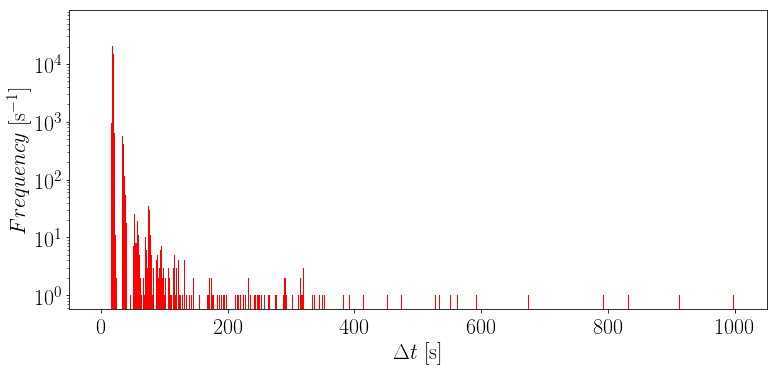

In [11]:
#plot and calculation to show the spread in collection intervals of wind column output from the lidar
#use this cell to find the interpolation timescale to grid the lidar data

longdel_ts_l = 1000 #current arbitrary, should be largest eddy timescale, needs to be int

S=4
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax = plt.subplot(111)
ts_l_diff_hist = ax.hist(np.diff(ts_l),bins=longdel_ts_l,range=[0,longdel_ts_l],color='r',log=True)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.xlabel('$\Delta t$ [s]',fontsize=22)
plt.ylabel('$Frequency$ [s$^{-1}$]',fontsize=22)

fig = plt.gcf()
fig.set_size_inches(12.5, 5.5, forward=True)

shortdel_ts_l = ts_l_diff_hist[1][np.argmax(ts_l_diff_hist[0])]

In [12]:
shortdel_ts_l

17.0

In [13]:
# make the lidar data evenly spaced:
#     do this by finding average frequency of raw data (above)
#     use that at this spacing
#     don't want to interpolate across large spans of missing data so
#     find sub series where all the elements are closer than a sufficiently short timescale (largest eddy)
#     then evenly space each of these sub series, append them at the end
#     what interpolation method to use? (int for kind is order of spline 1,2,3 in scipy.interpolate.interp1d)
# this will be useful for: fft, reynolds decomp, cup calibration, comparing days

Tifs_l = np.argwhere(np.diff(ts_l)>longdel_ts_l)
Tiis_l = Tifs_l+1

Tifs_l = np.append(Tifs_l,np.shape(ts_l)[0]-1)
Tiis_l = np.append(0,Tiis_l)

bad_index = []
for i in range(0,np.shape(Tiis_l)[0]):
    if ts_l[Tiis_l[i]]+longdel_ts_l*3 > ts_l[Tifs_l[i]]:
        bad_index = np.append(bad_index,i)
        
Tifs_l = np.delete(Tifs_l,bad_index)  
Tiis_l = np.delete(Tiis_l,bad_index) 

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [14]:
# grid the lidar (interpolation) and cup (smooth over shortdel_ts_l then interpolate) data over shortdel_ts_l

spline_order = 1

tgs_l = []

Tg_l = []
pg_l = []
hg_l = []

u0g_l = []
u1g_l = []
u2g_l = []
u3g_l = []
u4g_l = []
u5g_l = []
u6g_l = []
u7g_l = []
u8g_l = []
u9g_l = []
u10g_l = []
u11g_l = []

w1g_l = []
w2g_l = []
w3g_l = []
w4g_l = []
w5g_l = []
w6g_l = []
w7g_l = []
w8g_l = []
w9g_l = []
w10g_l = []
w11g_l = []

tgls_c = []

u0gl_c = []
u1gl_c = []
u2gl_c = []
u3gl_c = []

tgls_m = []

Tgl_m = []
pgl_m = []
hgl_m = []

u0smoothl_c = convolve(u0_c, Box1DKernel(boxcar_width(shortdel_ts_l/tdel_ts_c)))
u1smoothl_c = convolve(u1_c, Box1DKernel(boxcar_width(shortdel_ts_l/tdel_ts_c)))
u2smoothl_c = convolve(u2_c, Box1DKernel(boxcar_width(shortdel_ts_l/tdel_ts_c)))
u3smoothl_c = convolve(u3_c, Box1DKernel(boxcar_width(shortdel_ts_l/tdel_ts_c)))

tgls_s = []

CNgl_s = []
KEgl_s = []

CNsmoothl_s = convolve(CN_s, Box1DKernel(boxcar_width(shortdel_ts_l/tdel_ts_s)))
KEsmoothl_s = convolve(KE_s, Box1DKernel(boxcar_width(shortdel_ts_l/tdel_ts_s)))

tgls_g = []

pdgl_g = []

for i in range(0,np.shape(Tiis_l)[0]): #i = 4 is longest uninterrupted stretch
    
    ttemp = np.arange(ts_l[Tiis_l[i]],ts_l[Tifs_l[i]],step=shortdel_ts_l)
    ttemp = ttemp[ttemp<ts_l[Tifs_l[i]]]
    tgs_l = np.append(tgs_l,ttemp)

    # lidar gridding
    
    fT_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],T_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    Ttemp_l = fT_l(ttemp)
    Tg_l = np.append(Tg_l,Ttemp_l)
    
    fp_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],p_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    ptemp_l = fp_l(ttemp)
    pg_l = np.append(pg_l,ptemp_l)
    
    fh_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],h_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    htemp_l = fh_l(ttemp)
    hg_l = np.append(hg_l,htemp_l)
    
    fp_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],p_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    ptemp_l = fp_l(ttemp)
    pg_l = np.append(pg_l,ptemp_l)
    
    fh_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],h_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    htemp_l = fh_l(ttemp)
    hg_l = np.append(hg_l,htemp_l)
    
    fu0_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u0_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u0temp_l = fu0_l(ttemp)
    u0g_l = np.append(u0g_l,u0temp_l)
    
    fu1_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u1_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u1temp_l = fu1_l(ttemp)
    u1g_l = np.append(u1g_l,u1temp_l)
    
    fu2_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u2_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u2temp_l = fu2_l(ttemp)
    u2g_l = np.append(u2g_l,u2temp_l)
    
    fu3_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u3_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u3temp_l = fu3_l(ttemp)
    u3g_l = np.append(u3g_l,u3temp_l)
    
    fu4_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u4_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u4temp_l = fu4_l(ttemp)
    u4g_l = np.append(u4g_l,u4temp_l)
    
    fu5_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u5_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u5temp_l = fu5_l(ttemp)
    u5g_l = np.append(u5g_l,u5temp_l)
    
    fu6_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u6_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u6temp_l = fu6_l(ttemp)
    u6g_l = np.append(u6g_l,u6temp_l)
    
    fu7_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u7_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u7temp_l = fu7_l(ttemp)
    u7g_l = np.append(u7g_l,u7temp_l)
    
    fu8_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u8_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u8temp_l = fu8_l(ttemp)
    u8g_l = np.append(u8g_l,u8temp_l)
    
    fu9_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u9_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u9temp_l = fu9_l(ttemp)
    u9g_l = np.append(u9g_l,u9temp_l)
    
    fu10_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u10_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u10temp_l = fu10_l(ttemp)
    u10g_l = np.append(u10g_l,u10temp_l)
    
    fu11_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],u11_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    u11temp_l = fu11_l(ttemp)
    u11g_l = np.append(u11g_l,u11temp_l)
    
    fw1_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w1_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w1temp_l = fw1_l(ttemp)
    w1g_l = np.append(w1g_l,w1temp_l)
    
    fw2_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w2_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w2temp_l = fw2_l(ttemp)
    w2g_l = np.append(w2g_l,w2temp_l)
    
    fw3_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w3_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w3temp_l = fw3_l(ttemp)
    w3g_l = np.append(w3g_l,w3temp_l)
    
    fw4_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w4_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w4temp_l = fw4_l(ttemp)
    w4g_l = np.append(w4g_l,w4temp_l)
    
    fw5_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w5_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w5temp_l = fw5_l(ttemp)
    w5g_l = np.append(w5g_l,w5temp_l)
    
    fw6_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w6_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w6temp_l = fw6_l(ttemp)
    w6g_l = np.append(w6g_l,w6temp_l)
    
    fw7_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w7_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w7temp_l = fw7_l(ttemp)
    w7g_l = np.append(w7g_l,w7temp_l)
    
    fw8_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w8_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w8temp_l = fw8_l(ttemp)
    w8g_l = np.append(w8g_l,w8temp_l)
    
    fw9_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w9_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w9temp_l = fw9_l(ttemp)
    w9g_l = np.append(w9g_l,w9temp_l)
    
    fw10_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w10_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w10temp_l = fw10_l(ttemp)
    w10g_l = np.append(w10g_l,w10temp_l)
    
    fw11_l = scipy.interpolate.interp1d(ts_l[Tiis_l[i]:Tifs_l[i]+1],w11_l[Tiis_l[i]:Tifs_l[i]+1],kind=spline_order) 
    w11temp_l = fw11_l(ttemp)
    w11g_l = np.append(w11g_l,w11temp_l)

    # cups gridding
    # gotta make sure the start and ends that go in the interp are wider than ttemp
    
    ttemp = np.arange(ts_l[Tiis_l[i]],ts_l[Tifs_l[i]],step=shortdel_ts_l)
    ttemp = ttemp[ttemp<ts_l[Tifs_l[i]]]
    tgls_c = np.append(tgls_c,ttemp)
    
    Tiis_c = (np.abs(ts_c - ttemp[0])).argmin()
    Tifs_c = (np.abs(ts_c - ttemp[-1])).argmin()
    
    if ts_c[Tiis_c]>ttemp[0]:
        Tiis_c = Tiis_c-1
    if ts_c[Tifs_c]<ttemp[-1]:
        Tifs_c = Tifs_c+1
        
    fu0_c = scipy.interpolate.interp1d(ts_c[Tiis_c:Tifs_c+1],u0smoothl_c[Tiis_c:Tifs_c+1],kind=spline_order) 
    u0temp_c = fu0_c(ttemp)
    u0gl_c = np.append(u0gl_c,u0temp_c)
    
    fu1_c = scipy.interpolate.interp1d(ts_c[Tiis_c:Tifs_c+1],u1smoothl_c[Tiis_c:Tifs_c+1],kind=spline_order) 
    u1temp_c = fu1_c(ttemp)
    u1gl_c = np.append(u1gl_c,u1temp_c)
    
    fu2_c = scipy.interpolate.interp1d(ts_c[Tiis_c:Tifs_c+1],u2smoothl_c[Tiis_c:Tifs_c+1],kind=spline_order) 
    u2temp_c = fu2_c(ttemp)
    u2gl_c = np.append(u2gl_c,u2temp_c)
    
    fu3_c = scipy.interpolate.interp1d(ts_c[Tiis_c:Tifs_c+1],u3smoothl_c[Tiis_c:Tifs_c+1],kind=spline_order) 
    u3temp_c = fu3_c(ttemp)
    u3gl_c = np.append(u3gl_c,u3temp_c)
    
    # WHSA2 gridding
    # gotta make sure the start and ends that go in the interp are wider than ttemp
    
    ttemp = np.arange(ts_l[Tiis_l[i]],ts_l[Tifs_l[i]],step=shortdel_ts_l)
    ttemp = ttemp[ttemp<ts_l[Tifs_l[i]]]
    tgls_m = np.append(tgls_m,ttemp)
    
    Tiis_m = (np.abs(ts_m - ttemp[0])).argmin()
    Tifs_m = (np.abs(ts_m - ttemp[-1])).argmin()
    
    if ts_m[Tiis_m]>ttemp[0]:
        Tiis_m = Tiis_m-1
    if ts_m[Tifs_m]<ttemp[-1]:
        Tifs_m = Tifs_m+1
        
    fT_m = scipy.interpolate.interp1d(ts_m[Tiis_m:Tifs_m+1],T_m[Tiis_m:Tifs_m+1],kind=spline_order) 
    Ttemp_m = fT_m(ttemp)
    Tgl_m = np.append(Tgl_m,Ttemp_m)
    
    fp_m = scipy.interpolate.interp1d(ts_m[Tiis_m:Tifs_m+1],p_m[Tiis_m:Tifs_m+1],kind=spline_order) 
    ptemp_m = fp_m(ttemp)
    pgl_m = np.append(pgl_m,ptemp_m)
    
    fh_m = scipy.interpolate.interp1d(ts_m[Tiis_m:Tifs_m+1],h_m[Tiis_m:Tifs_m+1],kind=spline_order) 
    htemp_m = fh_m(ttemp)
    hgl_m = np.append(hgl_m,htemp_m)
    
    # sensit gridding
        
    ttemp = np.arange(ts_l[Tiis_l[i]],ts_l[Tifs_l[i]],step=shortdel_ts_l)
    ttemp = ttemp[ttemp<ts_l[Tifs_l[i]]]
    tgls_s = np.append(tgls_s,ttemp)
    
    Tiis_s = (np.abs(ts_s - ttemp[0])).argmin()
    Tifs_s = (np.abs(ts_s - ttemp[-1])).argmin()
    
    if ts_s[Tiis_s]>ttemp[0]:
        Tiis_s = Tiis_s-1
    if ts_s[Tifs_s]<ttemp[-1]:
        Tifs_s = Tifs_s+1
        
    fCN_s = scipy.interpolate.interp1d(ts_s[Tiis_s:Tifs_s+1],CNsmoothl_s[Tiis_s:Tifs_s+1],kind=spline_order) 
    CNtemp_s = fCN_s(ttemp)
    CNgl_s = np.append(CNgl_s,CNtemp_s)
    
    fKE_s = scipy.interpolate.interp1d(ts_s[Tiis_s:Tifs_s+1],KEsmoothl_s[Tiis_s:Tifs_s+1],kind=spline_order) 
    KEtemp_s = fKE_s(ttemp)
    KEgl_s = np.append(KEgl_s,KEtemp_s)
    
    # GOES gridding
    # gotta make sure the start and ends that go in the interp are wider than ttemp
    
    ttemp = np.arange(ts_l[Tiis_l[i]],ts_l[Tifs_l[i]],step=shortdel_ts_l)
    ttemp = ttemp[ttemp<ts_l[Tifs_l[i]]]
    tgls_g = np.append(tgls_g,ttemp)
    
    Tiis_g = (np.abs(ts_g - ttemp[0])).argmin()
    Tifs_g = (np.abs(ts_g - ttemp[-1])).argmin()
    
    if ts_g[Tiis_g]>ttemp[0]:
        Tiis_g = Tiis_g-1
    if ts_g[Tifs_g]<ttemp[-1]:
        Tifs_g = Tifs_g+1
        
    fpd_g = scipy.interpolate.interp1d(ts_g[Tiis_g:Tifs_g+1],pd_g[Tiis_g:Tifs_g+1],kind=spline_order) 
    pdtemp_g = fpd_g(ttemp)
    pdgl_g = np.append(pdgl_g,pdtemp_g)
    
tgd_l = tgs_l*s_2_d
tgld_c = tgls_c*s_2_d
tgld_m = tgls_m*s_2_d
tgld_s = tgls_s*s_2_d
tgld_g = tgls_g*s_2_d

In [15]:
#####################
## BULK RICHARDSON ##
#####################
# virtual temp, virtual potential temp and bulk richardson number calculations
# used AMS glossary to get the definitions i.e. http://glossary.ametsoc.org/wiki/Potential_temperature
# used this to assure right units https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf

c_2_K = 273.15

rvgl_l = 0.622*(6.11/100*hgl_m*10**(7.5*Tg_l/(Tg_l+c_2_K)))/(pgl_m-6.11/100*hgl_m*10**(7.5*Tg_l/(Tg_l+c_2_K)))
rvgl_m = 0.622*(6.11/100*hgl_m*10**(7.5*Tgl_m/(Tgl_m+c_2_K)))/(pgl_m-6.11/100*hgl_m*10**(7.5*Tgl_m/(Tgl_m+c_2_K)))

Tvgl_l = (1+0.61*rvgl_l)*Tg_l
Tvgl_m = (1+0.61*rvgl_m)*Tgl_m

PTgl_l = (Tg_l+c_2_K)*(p_ref/pgl_m)**(0.2854*(1-0.24*rvgl_l))
PTgl_m = (Tgl_m+c_2_K)*(p_ref/pgl_m)**(0.2854*(1-0.24*rvgl_m))

PTvgl_l = (1+0.61*rvgl_l)*PTgl_l
PTvgl_m = (1+0.61*rvgl_m)*PTgl_m

dTdzfit = (PTvgl_m-PTvgl_l)/(z_T-z_l[0])

In [16]:
np.mean(rvgl_l)

0.0023311539671456807

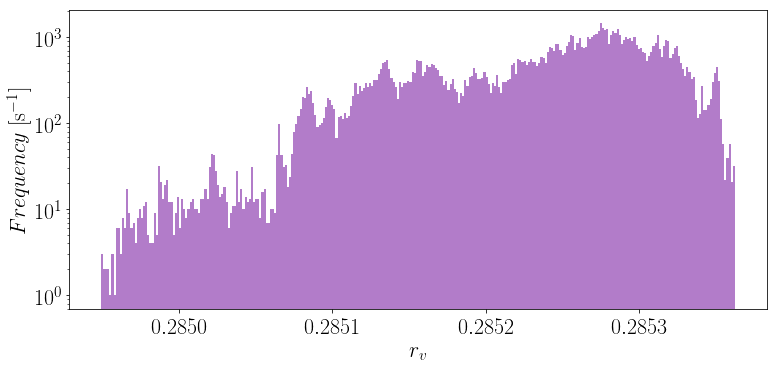

In [18]:
#plot and calculation to show the spread in collection intervals of wind column output from the lidar
#use this cell to find the interpolation timescale to grid the lidar data

S=4
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax = plt.subplot(111)
sc1 = ax.hist((0.2854*(1-0.24*rvgl_l)),bins=300,color='r',log=True,alpha=0.3)
sc1 = ax.hist((0.2854*(1-0.24*rvgl_l)),bins=300,color='b',log=True,alpha=0.3)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.xlabel('$r_v$',fontsize=22)
plt.ylabel('$Frequency$ [s$^{-1}$]',fontsize=22)

fig = plt.gcf()
fig.set_size_inches(12.5, 5.5, forward=True)

In [19]:
#energy spectra and structure function of sand transport calculation
# only doing this on the interval of gridded (must be for fft) data that is longest (must be uninterrupted for fft)
# use a moving hanning window to avoid spectral leakage
# takes segmM*2-1 windows that have 50% overlap
# averages the fft of them
# also do the entire time series to get the structure function

fullu = KE_s[:-1] #make nice factorable integer

fullN = int(np.shape(fullu)[0])

segmM = 5*5 #number of windows is segmM*2-1
# (np.shape(KE_s[:-1])[0]*tdel_ts_s/5/5)/60/60/24 = 2.2358796296296295 i.e. each segment is over 2 days

x = np.empty([2*segmM-1,int(fullN/segmM)])
for i in range(0,segmM):
    x[i] = fullu[int(i*fullN/segmM):int((i+1)*fullN/segmM)]
for i in range(0,segmM-1):
    x[segmM+i] = fullu[int((i+0.5)*fullN/segmM):int((i+1.5)*fullN/segmM)]
    
han = np.hanning(int(fullN/segmM))

TKEu = np.empty_like(x)

for i in range(0,np.shape(x)[0]):
    curx = x[i,:]
    temp = 1/np.shape(curx)[0]*np.fft.fft(han*curx,axis=0)
    TKEu[i] = ((temp*np.conj(temp)).real)**(1/2)

lt_s = np.shape(x)[1]*tdel_ts_s
wo_s = 2*np.pi/lt_s*np.arange(0,np.shape(x)[1])

KEfft_s = np.mean(TKEu,axis=0)

KERtry_s = np.fft.fftshift(np.fft.ifft(KEfft_s))
KERtry_s = KERtry_s.real/np.max(KERtry_s.real)
tsRtry_s = np.linspace(-lt_s/2,lt_s/2,np.shape(x)[1])
tdRtry_s = tsRtry_s*s_2_d

###########################

han = np.hanning(np.shape(KE_s)[0])

temp = 1/np.shape(KE_s)[0]*np.fft.fft(han*KE_s,axis=0)
KERfft_s = ((temp*np.conj(temp)).real)**(1/2)

lt_s = ts_s[-1]-ts_s[0]

woR_s = 2*np.pi/lt_s*np.arange(0,np.shape(KE_s)[0])

KER_s = np.fft.fftshift(np.fft.ifft(KERfft_s))
KER_s = KER_s.real/np.max(KER_s.real)
tsR_s = np.linspace(-lt_s/2,lt_s/2,np.shape(KE_s)[0])
KElam_s = scipy.integrate.trapz(KER_s,tsR_s)/2

In [16]:
import pickle

if laptop==True:
    %cd /home/andle/Documents/Python/trajs
else:
    %cd /home/andrew/Documents/Python/trajs

with open('y.pkl', 'rb') as f:
    y = pickle.load(f)
with open('ym.pkl', 'rb') as f:
    ym = pickle.load(f)
with open('y25.pkl', 'rb') as f:
    y25 = pickle.load(f)
with open('y75.pkl', 'rb') as f:
    y75 = pickle.load(f)
    
with open('x1.pkl', 'rb') as f:
    x1 = pickle.load(f)
with open('x1m.pkl', 'rb') as f:
    x1m = pickle.load(f)
with open('x125.pkl', 'rb') as f:
    x125 = pickle.load(f)
with open('x175.pkl', 'rb') as f:
    x175 = pickle.load(f)

with open('x2.pkl', 'rb') as f:
    x2 = pickle.load(f)
with open('x2m.pkl', 'rb') as f:
    x2m = pickle.load(f)
with open('x225.pkl', 'rb') as f:
    x225 = pickle.load(f)
with open('x275.pkl', 'rb') as f:
    x275 = pickle.load(f)
    
with open('x3.pkl', 'rb') as f:
    x3 = pickle.load(f)
with open('x3m.pkl', 'rb') as f:
    x3m = pickle.load(f)
with open('x325.pkl', 'rb') as f:
    x325 = pickle.load(f)
with open('x375.pkl', 'rb') as f:
    x375 = pickle.load(f)
    
with open('cn.pkl', 'rb') as f:
    cn = pickle.load(f)
with open('cnm.pkl', 'rb') as f:
    cnm = pickle.load(f)
with open('cn25.pkl', 'rb') as f:
    cn25 = pickle.load(f)
with open('cn75.pkl', 'rb') as f:
    cn75 = pickle.load(f)
    
with open('h.pkl', 'rb') as f:
    h = pickle.load(f)
with open('hm.pkl', 'rb') as f:
    hm = pickle.load(f)
with open('h25.pkl', 'rb') as f:
    h25 = pickle.load(f)
with open('h75.pkl', 'rb') as f:
    h75 = pickle.load(f)

/home/andrew/Documents/Python/trajs


In [17]:
temp1 = tgd_l%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)
td = temp1
tt = tgl_traj

import shapely.geometry as sg
import shapely.ops as so

r2d = []
for i in range(0,np.shape(tt)[0]):
    r2d.append(sg.box(x225[i],y25[i],x275[i],y75[i]))
new_shape2d = so.cascaded_union(r2d)
xo2d, yo2d = new_shape2d.exterior.xy

In [18]:
import pickle

if laptop==True:
    %cd /home/andle/Documents/Python/trajs
else:
    %cd /home/andrew/Documents/Python/trajs

with open('xo2d.pkl', 'wb') as f:
    pickle.dump(xo2d, f)
with open('yo2d.pkl', 'wb') as f:
    pickle.dump(yo2d, f)
with open('tt.pkl', 'wb') as f:
    pickle.dump(tt, f)

/home/andrew/Documents/Python/trajs


In [21]:
# z0xxx = np.median(z0_c[~np.isnan(z0_c)])
z0xxx = 0.1
xx1 = x2m*np.log(300/z0xxx)/np.log(10/z0xxx)
xx3 = x2m*np.log(0.32/z0xxx)/np.log(10/z0xxx)

XX1 = x1/(x2*np.log(300/z0xxx)/np.log(10/z0xxx))
XX3 = x3/(x2*np.log(0.32/z0xxx)/np.log(10/z0xxx))

smooth_timescale = 1*60*60 #1 hour
traj_smoothgl = boxcar_width(smooth_timescale*np.shape(tgd_l)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

temp1 = tgd_l%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)
td = temp1
tt = tgl_traj

temp2 = XX1[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

XX1m = temp3
XX125 = temp41
XX175 = temp42


temp2 = XX3[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)


XX3m = temp3
XX325 = temp41
XX375 = temp42

In [22]:
temp1 = tgd_l%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)
td = temp1
tt = tgl_traj

import shapely.geometry as sg
import shapely.ops as so

r1d = []
for i in range(0,np.shape(tt)[0]):
    r1d.append(sg.box(x125[i],y25[i],x175[i],y75[i]))
new_shape1d = so.cascaded_union(r1d)
xo1d, yo1d = new_shape1d.exterior.xy

r2d = []
for i in range(0,np.shape(tt)[0]):
    r2d.append(sg.box(x225[i],y25[i],x275[i],y75[i]))
new_shape2d = so.cascaded_union(r2d)
xo2d, yo2d = new_shape2d.exterior.xy

r3d = []
for i in range(0,np.shape(tt)[0]):
    r3d.append(sg.box(x325[i],y25[i],x375[i],y75[i]))
new_shape3d = so.cascaded_union(r3d)
xo3d, yo3d = new_shape3d.exterior.xy

r4d = []
for i in range(0,np.shape(tt)[0]):
    r4d.append(sg.box(h25[i],y25[i],h75[i],y75[i]))
new_shape4d = so.cascaded_union(r4d)
xo4d, yo4d = new_shape4d.exterior.xy

r5d = []
for i in range(0,np.shape(tt)[0]):
    r5d.append(sg.box(XX125[i],y25[i],XX175[i],y75[i]))
new_shape5d = so.cascaded_union(r5d)
xo5d, yo5d = new_shape5d.exterior.xy

r6d = []
for i in range(0,np.shape(tt)[0]):
    r6d.append(sg.box(XX325[i],y25[i],XX375[i],y75[i]))
new_shape6d = so.cascaded_union(r6d)
xo6d, yo6d = new_shape6d.exterior.xy

In [23]:
# boxcar smooth the particle count time series by the timescale under the structure function
# for periods in the smoothed time series greater than the average particle count in the deployment,
# call those periods transport events

KEsmooths_s = convolve(KE_s, Box1DKernel(boxcar_width(KElam_s/tdel_ts_s)))

# epsKE = np.mean(KE_s)
epsKE = np.percentile(KE_s[KE_s!=0],25)

KEsmoothsTHR_s = np.copy(KEsmooths_s)
KEsmoothsTHR_s[KEsmoothsTHR_s<epsKE] = np.nan
tdTHR_s = np.copy(td_s)
tdTHR_s[KEsmooths_s<epsKE] = np.nan

eventw_i = [0]
eventw_f = [0]

for i in range(1,np.shape(KEsmoothsTHR_s)[0]-1):
    if (np.isnan(KEsmoothsTHR_s[i-1])==True) & (np.isnan(KEsmoothsTHR_s[i])==False):
        eventw_i = np.append(eventw_i,tdTHR_s[i])
    if (np.isnan(KEsmoothsTHR_s[i])==False) & (np.isnan(KEsmoothsTHR_s[i+1])==True):
        eventw_f = np.append(eventw_f,tdTHR_s[i])

eventw_i = np.append(eventw_i,td_s[-1])
eventw_f = np.append(eventw_f,td_s[-1])

In [24]:
#find dust emission events

gthr = 0.5

pdTHR_g = np.copy(pd_g)
pdTHR_g[pdTHR_g<gthr] = np.nan
tdTHR_g = np.copy(td_g)
tdTHR_g[pdTHR_g<gthr] = np.nan

eventg_i = [0]
eventg_f = [0]

for i in range(1,np.shape(pdTHR_g)[0]-1):
    if (np.isnan(pdTHR_g[i-1])==True) & (np.isnan(pdTHR_g[i])==False):
        eventg_i = np.append(eventg_i,tdTHR_g[i])
    if (np.isnan(pdTHR_g[i])==False) & (np.isnan(pdTHR_g[i+1])==True):
        eventg_f = np.append(eventg_f,tdTHR_g[i])

eventg_i = np.append(eventg_i,td_g[-1])
eventg_f = np.append(eventg_f,td_g[-1])

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


In [25]:
# tells where the gridded intervals of lidar data are

Tiigs_l = []
Tifgs_l = []

temp = np.diff(tgs_l)
for i in range(0,len(temp[temp!=shortdel_ts_l])+1):
    idxi = (np.abs(tgs_l- ts_l[Tiis_l[i]])).argmin()
    idxf = (np.abs(tgs_l- ts_l[Tifs_l[i]])).argmin()
    
    Tiigs_l = np.append(Tiigs_l,idxi)
    Tifgs_l = np.append(Tifgs_l,idxf)
    
    print('start index: ',idxi,', end index: ',idxf,', interval duration: ',(idxf-idxi)*17*s_2_d,' days')

Tiigs_l = Tiigs_l.astype(int)
Tifgs_l = Tifgs_l.astype(int)
temp = (Tifgs_l-Tiigs_l).argmax()
Tiigs_l_long = Tiigs_l[temp]
Tifgs_l_long = Tifgs_l[temp]

start index:  0 , end index:  79241 , interval duration:  15.591400462962962  days
start index:  79242 , end index:  82246 , interval duration:  0.5910648148148148  days
start index:  82247 , end index:  83844 , interval duration:  0.314224537037037  days
start index:  83845 , end index:  85100 , interval duration:  0.24693287037037034  days
start index:  85101 , end index:  87349 , interval duration:  0.44231481481481477  days
start index:  87350 , end index:  91700 , interval duration:  0.8559027777777778  days
start index:  91701 , end index:  99413 , interval duration:  1.5174074074074073  days
start index:  99414 , end index:  100217 , interval duration:  0.15799768518518517  days


In [26]:
# grid measures onto the WHSA2 10 min grid only in regions where all are observed

spline_order = 1

tgms_lmcs = []

KEgm_s = []

u1gm_l = []
u2gm_l = []
u3gm_l = []
u4gm_l = []
u5gm_l = []
u6gm_l = []
u7gm_l = []
u8gm_l = []
u9gm_l = []
u10gm_l = []
u11gm_l = []
gammagm_l = []

u0gm_m = []
u1gm_m = []
hgm_m = []

u0gm_c = []
u1gm_c = []
u3gm_c = []

pdgm_g = []

KEsmoothm_s = convolve(KE_s, Box1DKernel(boxcar_width(tdel_ts_m/tdel_ts_s)))

u1smoothm_l = convolve(u1g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u2smoothm_l = convolve(u2g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u3smoothm_l = convolve(u3g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u4smoothm_l = convolve(u4g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u5smoothm_l = convolve(u5g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u6smoothm_l = convolve(u6g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u7smoothm_l = convolve(u7g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u8smoothm_l = convolve(u8g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u9smoothm_l = convolve(u9g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u10smoothm_l = convolve(u10g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))
u11smoothm_l = convolve(u11g_l, Box1DKernel(boxcar_width(tdel_ts_m/shortdel_ts_l)))

u0smoothm_c = convolve(u0_c, Box1DKernel(boxcar_width(tdel_ts_m/tdel_ts_c)))
u1smoothm_c = convolve(u1_c, Box1DKernel(boxcar_width(tdel_ts_m/tdel_ts_c)))
u3smoothm_c = convolve(u3_c, Box1DKernel(boxcar_width(tdel_ts_m/tdel_ts_c)))

pdsmoothm_g = convolve(pd_g, Box1DKernel(boxcar_width(tdel_ts_m/tdel_ts_g)))

for i in range(0,np.shape(Tiigs_l)[0]):

    Tiis_m = (np.abs(ts_m - tgs_l[Tiigs_l[i]])).argmin()
    Tifs_m = (np.abs(ts_m - tgs_l[Tifgs_l[i]])).argmin()
    
    if ts_m[Tiis_m]<tgs_l[Tiigs_l[i]]:
        Tiis_m = Tiis_m+1
    if ts_m[Tifs_m]>tgs_l[Tifgs_l[i]]:
        Tifs_m = Tifs_m-1
    
    ttemp = ts_m[Tiis_m:Tifs_m]
    
    tgms_lmcs = np.append(tgms_lmcs,ttemp)    
    
    # sensit
    # always will have a val where there is a met val because it outputs then too (but also at higher freq)
    
    Tiis_s = int(np.argwhere(ts_s==ts_m[Tiis_m]))
    Tifs_s = int(np.argwhere(ts_s==ts_m[Tifs_m]))

    fKE_s = scipy.interpolate.interp1d(ts_s[Tiis_s:Tifs_s+1],KEsmoothm_s[Tiis_s:Tifs_s+1],kind=spline_order) 
    KEtemp_s = fKE_s(ttemp)
    KEgm_s = np.append(KEgm_s,KEtemp_s)

    # lidar
    
    fu1g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u1smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u1gtemp_l = fu1g_l(ttemp)
    u1gm_l = np.append(u1gm_l,u1gtemp_l)
    
    fu2g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u2smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u2gtemp_l = fu2g_l(ttemp)
    u2gm_l = np.append(u2gm_l,u2gtemp_l)
    
    fu3g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u3smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u3gtemp_l = fu3g_l(ttemp)
    u3gm_l = np.append(u3gm_l,u3gtemp_l)
    
    fu4g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u4smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u4gtemp_l = fu4g_l(ttemp)
    u4gm_l = np.append(u4gm_l,u4gtemp_l)
    
    fu5g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u5smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u5gtemp_l = fu5g_l(ttemp)
    u5gm_l = np.append(u5gm_l,u5gtemp_l)
    
    fu6g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u6smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u6gtemp_l = fu6g_l(ttemp)
    u6gm_l = np.append(u6gm_l,u6gtemp_l)
    
    fu7g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u7smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u7gtemp_l = fu7g_l(ttemp)
    u7gm_l = np.append(u7gm_l,u7gtemp_l)
    
    fu8g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u8smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u8gtemp_l = fu8g_l(ttemp)
    u8gm_l = np.append(u8gm_l,u8gtemp_l)
    
    fu9g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u9smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u9gtemp_l = fu9g_l(ttemp)
    u9gm_l = np.append(u9gm_l,u9gtemp_l)
    
    fu10g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u10smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u10gtemp_l = fu10g_l(ttemp)
    u10gm_l = np.append(u10gm_l,u10gtemp_l)
    
    fu11g_l = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],u11smoothm_l[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    u11gtemp_l = fu11g_l(ttemp)
    u11gm_l = np.append(u11gm_l,u11gtemp_l)
    
    fgamma = scipy.interpolate.interp1d(tgs_l[Tiigs_l[i]:Tifgs_l[i]+1],dTdzfit[Tiigs_l[i]:Tifgs_l[i]+1],kind=spline_order) 
    gammatemp = fgamma(ttemp)
    gammagm_l = np.append(gammagm_l,gammatemp)
    
    # WHSA2
    
    u0gm_m = np.append(u0gm_m,u0_m[Tiis_m:Tifs_m])
    u1gm_m = np.append(u1gm_m,u1_m[Tiis_m:Tifs_m])
    
    hgm_m = np.append(hgm_m,h_m[Tiis_m:Tifs_m])
    
    # CUPS

    Tiis_c = (np.abs(ts_c - ttemp[0])).argmin()
    Tifs_c = (np.abs(ts_c - ttemp[-1])).argmin()
    
    if ts_c[Tiis_c]>ttemp[0]:
        Tiis_c = Tiis_c-1
    if ts_c[Tifs_c]<ttemp[-1]:
        Tifs_c = Tifs_c+1
        
    fu0_c = scipy.interpolate.interp1d(ts_c[Tiis_c:Tifs_c+1],u0smoothm_c[Tiis_c:Tifs_c+1],kind=spline_order) 
    u0temp_c = fu0_c(ttemp)
    u0gm_c = np.append(u0gm_c,u0temp_c)
    
    fu1_c = scipy.interpolate.interp1d(ts_c[Tiis_c:Tifs_c+1],u1smoothm_c[Tiis_c:Tifs_c+1],kind=spline_order) 
    u1temp_c = fu1_c(ttemp)
    u1gm_c = np.append(u1gm_c,u1temp_c)

    fu3_c = scipy.interpolate.interp1d(ts_c[Tiis_c:Tifs_c+1],u3smoothm_c[Tiis_c:Tifs_c+1],kind=spline_order) 
    u3temp_c = fu3_c(ttemp)
    u3gm_c = np.append(u3gm_c,u3temp_c)
    
    # GOES

    Tiis_g = (np.abs(ts_g - ttemp[0])).argmin()
    Tifs_g = (np.abs(ts_g - ttemp[-1])).argmin()
    
    if ts_g[Tiis_g]>ttemp[0]:
        Tiis_g = Tiis_g-1
    if ts_c[Tifs_g]<ttemp[-1]:
        Tifs_g = Tifs_g+1
        
    fpd_g = scipy.interpolate.interp1d(ts_g[Tiis_g:Tifs_g+1],pdsmoothm_g[Tiis_g:Tifs_g+1],kind=spline_order) 
    pdtemp_g = fpd_g(ttemp)
    pdgm_g = np.append(pdgm_g,pdtemp_g)
    
tgmd_lmcs = tgms_lmcs*s_2_d

In [27]:
##########################
## LAW OF THE WALL ONLY ##
##########################

#cups on met grid

z_cfit = np.asarray([z_c[0],z_c[1],z_c[3]])
ugm_cfit = np.asarray([u0gm_c,u1gm_c,u3gm_c])
uzgm_cfit = np.polyfit(np.log(z_cfit), ugm_cfit,deg=1)
usgm_c = uzgm_cfit[0]*kap
z0gm_c = np.exp(-uzgm_cfit[1]/uzgm_cfit[0])

#met on met grid

z_mfit = np.asarray([z_m[0],z_m[1]])
ugm_mfit = np.asarray([u0gm_m,u1gm_m])
uzgm_mfit = np.polyfit(np.log(z_mfit), ugm_mfit,deg=1)
usgm_m = uzgm_mfit[0]*kap
z0gm_m = np.exp(-uzgm_mfit[1]/uzgm_mfit[0])

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


In [28]:
def nMOint(vout,z,u):
    us = vout[0]
    z0  = vout[1]
    d = vout[2]
    k = 0.38
    return us*np.log((z-d)/z0)/k-u

def sMOint(vout,z,u):
    us = vout[0]
    z0  = vout[1]
    l = vout[2]
    d = vout[3]
    b1 = 5
    k = 0.38
    return us*(np.log((z-d)/z0)+b1*(z-d)/l)/k-u

def uMOint(vout,z,u):
    us = vout[0]
    z0  = vout[1]
    l = vout[2]
    d = vout[3]
    g1 = 16
    k = 0.38
    x = (1-g1*(z-d)/l)**(0.25)
    return us*(np.log((z-d)/z0)-2*np.log((1+x)/2)-np.log((1+x**2)/2)+2*np.arctan(x)-np.pi/2)/k-u

In [29]:
z_lM = z_l[1:9]
u_lM = np.asarray([u1gm_l,u2gm_l,u3gm_l,u4gm_l,u5gm_l,u6gm_l,u7gm_l,u8gm_l])


varthr = 50 #from looking at the histogram of varMOi 
varMOi = []

usNigm_l = []
z0Nigm_l = []
dNigm_l = []

usSigm_l = []
z0Sigm_l = []
LSigm_l = []
dSigm_l = []

usUigm_l = []
z0Uigm_l = []
LUigm_l = []
dUigm_l = []

usMOigm_l = []
z0MOigm_l = []
LMOigm_l = []
dMOigm_l = []

usgm_l = []
z0gm_l = []

x0nMOint = np.asarray([4e-1,1e-1,1e-0])
x0sMOint = np.asarray([4e-1,1e-1,1e+3,1e-0])
x0uMOint = np.asarray([4e-1,1e-1,-1e+3,1e-0])

# minimally constrained
nbounds=[[0,0,0],[np.inf,np.inf,np.inf]]
sbounds=[[0,0,0,0],[np.inf,np.inf,np.inf,np.inf]]
ubounds=[[0,0,-np.inf,0],[np.inf,np.inf,0,np.inf]]

# highly constrained
# sbounds=[[0,0,0],[2,10,np.inf]]
# ubounds=[[0,0,-np.inf],[2,10,0]]

xscale = [1e-2,1e-2,1e+1,1e-1]
xnscale = [1e-2,1e-2,1e-1]

for i in np.arange(0,np.shape(u_lM)[1]):

    tempu = [u_lM[0,i]]
    tempz = z_lM[0]
    for j in range(1,np.shape(u_lM)[0]):
        if u_lM[j,i]>tempu[-1]:            
            tempu = np.append(tempu,u_lM[j,i])
            tempz = np.append(tempz,z_lM[j])
        else:
            break
    
    if np.shape(tempu)[0]>3:
    
        ressMOi = least_squares(sMOint, x0sMOint, bounds=sbounds, x_scale=xscale, loss='cauchy', args=(tempz, tempu))
        resuMOi = least_squares(uMOint, x0uMOint, bounds=ubounds, x_scale=xscale, loss='cauchy', args=(tempz, tempu))
        usSigm_l.append(ressMOi.x[0])
        z0Sigm_l.append(ressMOi.x[1])
        LSigm_l.append(ressMOi.x[2])
        dSigm_l.append(ressMOi.x[3])
        usUigm_l.append(resuMOi.x[0])
        z0Uigm_l.append(resuMOi.x[1])
        LUigm_l.append(resuMOi.x[2])
        dUigm_l.append(resuMOi.x[3])
        
        uzgm_lfit = np.polyfit(np.log(tempz), tempu,deg=1)
        usgm_l.append(uzgm_lfit[0]*kap)
        z0gm_l.append(np.exp(-uzgm_lfit[1]/uzgm_lfit[0]))
        
        resnMOi = least_squares(nMOint, x0nMOint, bounds=nbounds, x_scale=xnscale, loss='cauchy', args=(tempz, tempu))
        usNigm_l.append(resnMOi.x[0])
        z0Nigm_l.append(resnMOi.x[1])
        dNigm_l.append(resnMOi.x[2])
        
        if np.sum(sMOint(ressMOi.x,tempz,tempu)**2)<np.sum(uMOint(resuMOi.x,tempz,tempu)**2):
            
            varMOi.append(np.sum(sMOint(ressMOi.x,tempz,tempu)**2)/np.shape(tempz)[0])
            
            if np.sum(sMOint(ressMOi.x,tempz,tempu)**2)/np.shape(tempz)[0]<varthr:
                usMOigm_l.append(ressMOi.x[0])
                z0MOigm_l.append(ressMOi.x[1])
                LMOigm_l.append(ressMOi.x[2])
                dMOigm_l.append(ressMOi.x[3])
                
            else:
                usMOigm_l.append(np.nan)
                z0MOigm_l.append(np.nan)
                LMOigm_l.append(np.nan)
                dMOigm_l.append(np.nan)
        else:
            
            varMOi.append(np.sum(uMOint(resuMOi.x,tempz,tempu)**2)/np.shape(tempz)[0])
            
            if np.sum(uMOint(resuMOi.x,tempz,tempu)**2)/np.shape(tempz)[0]<varthr:                
                usMOigm_l.append(resuMOi.x[0])
                z0MOigm_l.append(resuMOi.x[1])
                LMOigm_l.append(resuMOi.x[2])
                dMOigm_l.append(resuMOi.x[3])
                
            else:
                usMOigm_l.append(np.nan)
                z0MOigm_l.append(np.nan)
                LMOigm_l.append(np.nan) 
                dMOigm_l.append(np.nan)
        
    else:
        usNigm_l.append(np.nan)
        z0Nigm_l.append(np.nan)
        dNigm_l.append(np.nan)
        
        usUigm_l.append(np.nan)
        z0Uigm_l.append(np.nan)
        LUigm_l.append(np.nan)
        dUigm_l.append(np.nan)
        
        usSigm_l.append(np.nan)
        z0Sigm_l.append(np.nan)
        LSigm_l.append(np.nan)
        dSigm_l.append(np.nan)
        
        usMOigm_l.append(np.nan)
        z0MOigm_l.append(np.nan)
        LMOigm_l.append(np.nan)
        dMOigm_l.append(np.nan)
        
        usgm_l.append(np.nan)
        z0gm_l.append(np.nan)        

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


/home/andrew/Documents


/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


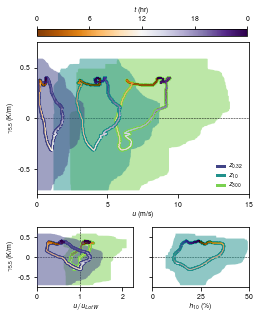

In [30]:
lw1 = 1
lw2 = 3
fs = 7

cmap = plt.cm.get_cmap('viridis')
c1 = cmap(0.2)
c2 = cmap(0.5)
c3 = cmap(0.8)

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

fig = plt.gcf()

ax = plt.subplot2grid((3, 2), (0, 0), rowspan=2, colspan=2)

p3 = np.array([x3m, ym]).T.reshape(-1, 1, 2)
segments3 = np.concatenate([p3[:-1], p3[1:]], axis=1)

lcol3 = LineCollection(segments3, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=40)
lcol3.set_array(tt)
lcol3.set_linewidth(lw1)

s3 = ax.add_collection(lcol3)

s = ax.plot(x3m,ym,c=c1,linewidth=lw2,label='$z_{0.32}$',zorder=35)

p2 = np.array([x2m, ym]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([p2[:-1], p2[1:]], axis=1)

lcol2 = LineCollection(segments2, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=30)
lcol2.set_array(tt)
lcol2.set_linewidth(lw1)

s2 = ax.add_collection(lcol2)

s = ax.plot(x2m,ym,c=c2,linewidth=lw2,label='$z_{10}$',zorder=25)

p1 = np.array([x1m, ym]).T.reshape(-1, 1, 2)
segments1 = np.concatenate([p1[:-1], p1[1:]], axis=1)

lcol1 = LineCollection(segments1, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=20)
lcol1.set_array(tt)
lcol1.set_linewidth(lw1)

s1 = ax.add_collection(lcol1)

s = ax.plot(x1m,ym,c=c3,linewidth=lw2,label='$z_{300}$',zorder=15)

s = ax.fill(xo3d, yo3d, alpha=0.5, fc=c1, ec='none',zorder=10)
s = ax.fill(xo2d, yo2d, alpha=0.5, fc=c2, ec='none',zorder=5)
s = ax.fill(xo1d, yo1d, alpha=0.5, fc=c3, ec='none',zorder=1)

s = ax.plot([0,15],[0,0],'--',c='k',linewidth=0.5,zorder=1)

plt.ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)
plt.xlabel('$u$ (m/s)', fontsize=fs)

plt.xlim([0,15])
plt.ylim([-0.75,0.75])
plt.xticks(np.linspace(0,15,4), ('0', '5', '10', '15'))
plt.yticks(np.linspace(-0.5,0.5,3), ('-0.5', '0', '0.5'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

cbar2_ax = fig.add_axes([0.125, 0.90, 0.77, 0.02])
cbar2 = fig.colorbar(s1, ticks=[0/4,1/4,2/4,3/4,4/4], cax=cbar2_ax, orientation='horizontal')
cbar2.ax.set_xticklabels(['0', '6', '12', '18', '0'])
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.set_label('$t$ (hr)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(labelsize=fs)

l = ax.legend(loc=4,frameon=False,fontsize=fs,handlelength=1)
l.set_zorder(45)

ax = plt.subplot2grid((3, 2), (2, 1))

p1 = np.array([hm, ym]).T.reshape(-1, 1, 2)
segments1 = np.concatenate([p1[:-1], p1[1:]], axis=1)

lcol1 = LineCollection(segments1, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=20)
lcol1.set_array(tt)
lcol1.set_linewidth(lw1)

s1 = ax.add_collection(lcol1)

s = ax.plot(hm,ym,c=c2,linewidth=lw2,label='$z_{10}$',zorder=15)

s = ax.fill(xo4d, yo4d, alpha=0.5, fc=c2, ec='none',zorder=10)

s = ax.plot([0,50],[0,0],'--',c='k',linewidth=0.5,zorder=1)

plt.xlabel('$h_{10}$ (\%)', fontsize=fs)

plt.xlim([0,50])
plt.ylim([-0.75,0.75])
plt.xticks(np.linspace(0,50,3), ('0', '25', '50'))
plt.yticks(np.linspace(-0.5,0.5,3), ('', '', ''))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

a = plt.subplot2grid((3, 2), (2, 0))

px3 = np.array([x3m/xx3, ym]).T.reshape(-1, 1, 2)
segmentsx3 = np.concatenate([px3[:-1], px3[1:]], axis=1)

lcolx3 = LineCollection(segmentsx3, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=25)
lcolx3.set_array(tt)
lcolx3.set_linewidth(lw1)

sx3 = a.add_collection(lcolx3)

s = a.plot(x3m/xx3,ym,c=c1,linewidth=lw2,zorder=20)

px1 = np.array([x1m/xx1, ym]).T.reshape(-1, 1, 2)
segmentsx1 = np.concatenate([px1[:-1], px1[1:]], axis=1)

lcolx1 = LineCollection(segmentsx1, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=15)
lcolx1.set_array(tt)
lcolx1.set_linewidth(lw1)

sx1 = a.add_collection(lcolx1)

s = a.plot(x1m/xx1,ym,c=c3,linewidth=lw2,zorder=10)

s = a.fill(xo6d, yo6d, alpha=0.5, fc=c1, ec='none',zorder=5)
s = a.fill(xo5d, yo5d, alpha=0.5, fc=c3, ec='none',zorder=1)

s = a.plot([1,1],[-0.8,0.8],'--',c='k',linewidth=0.5,zorder=1)
s = a.plot([0,2.25],[0,0],'--',c='k',linewidth=0.5,zorder=1)

plt.xlabel('$u/u_{LotW}$', fontsize=fs)
plt.ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.ylim([-0.75,0.75])
plt.xlim([0,2.25])
plt.xticks(np.linspace(0,2,3), ('0', '1', '2'))
plt.yticks(np.linspace(-0.5,0.5,3), ('-0.5', '0', '0.5'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.subplots_adjust(hspace=.55)

fig.set_size_inches(3.8, 4.5, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name64.pdf', bbox_inches='tight')

/home/andrew/Documents


/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


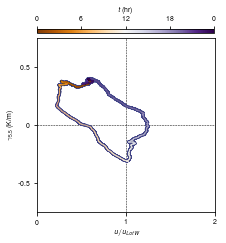

In [31]:
lw1 = 1
lw2 = 3
fs = 7

cmap = plt.cm.get_cmap('viridis')
c1 = cmap(0.2)
c2 = cmap(0.5)
c3 = cmap(0.8)

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

fig = plt.gcf()

a = plt.subplot(111)

px3 = np.array([x3m/xx3, ym]).T.reshape(-1, 1, 2)

lcolx3 = LineCollection(segmentsx3, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=25)
lcolx3.set_array(tt)
lcolx3.set_linewidth(lw1)

sx3 = a.add_collection(lcolx3)

s = a.plot(x3m/xx3,ym,c=c1,linewidth=lw2,zorder=20)

s = a.plot([1,1],[-0.8,0.8],'--',c='k',linewidth=0.5,zorder=1)
s = a.plot([0,2],[0,0],'--',c='k',linewidth=0.5,zorder=1)

plt.xlabel('$u/u_{LotW}$', fontsize=fs)
plt.ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.ylim([-0.75,0.75])
plt.xlim([0,2])
plt.xticks(np.linspace(0,2,3), ('0', '1', '2'))
plt.yticks(np.linspace(-0.5,0.5,3), ('-0.5', '0', '0.5'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

cbar2_ax = fig.add_axes([0.125, 0.90, 0.77, 0.02])
cbar2 = fig.colorbar(sx3, ticks=[0/4,1/4,2/4,3/4,4/4], cax=cbar2_ax, orientation='horizontal')
cbar2.ax.set_xticklabels(['0', '6', '12', '18', '0'])
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.set_label('$t$ (hr)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(labelsize=fs)

fig.set_size_inches(3.2, 3.2, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name69.pdf', bbox_inches='tight')

In [32]:
# 1 
xxx1 = np.copy(u0gm_c)
# 2 
xxx2 = np.copy(u0gm_m)
# 3 
xxx3 = np.copy(u1gm_l)
# 4 
xxx4 = np.copy(usgm_c)
# 5 
xxx5 = np.copy(usgm_m)
# 6 
xxx6 = np.copy(usNigm_l)
# 7 
xxx7 = np.copy(usMOigm_l)

yyy1 = np.copy(KEgm_s)

yyy2 = np.copy(pdgm_g)

zzz1 = np.copy(hgm_m)

In [33]:
n = 25

xxx3l = 0
xxx3h = 20
zzz1l = 0
zzz1h = 80
yyy1l = 0
yyy1h = 10
yyy2l = 0
yyy2h = 1

xxx3bins = np.linspace(xxx3l, xxx3h, n)
zzz1bins = np.linspace(zzz1l, zzz1h, n)
yyy1bins = np.linspace(yyy1l, yyy1h, n)
yyy2bins = np.linspace(yyy2l, yyy2h, n)

xxx3av_xxx3bins = (xxx3bins[:-1] + xxx3bins[1:])/2
zzz1av_zzz1bins = (zzz1bins[:-1] + zzz1bins[1:])/2

yyy1av_xxx3bins = np.empty(np.shape(xxx3av_xxx3bins)[0])
for i in np.arange(0,np.shape(yyy1av_xxx3bins)[0]):
    yyy1av_xxx3bins[i] = np.mean(yyy1[(xxx3>=xxx3bins[i])&(xxx3<=xxx3bins[i+1])])

yyy2av_xxx3bins = np.empty(np.shape(xxx3av_xxx3bins)[0])
for i in np.arange(0,np.shape(yyy2av_xxx3bins)[0]):
    yyy2av_xxx3bins[i] = np.mean(yyy2[(xxx3>=xxx3bins[i])&(xxx3<=xxx3bins[i+1])])
    
yyy1av_zzz1bins = np.empty(np.shape(zzz1av_zzz1bins)[0])
for i in np.arange(0,np.shape(yyy1av_zzz1bins)[0]):
    yyy1av_zzz1bins[i] = np.mean(yyy1[(zzz1>=zzz1bins[i])&(zzz1<=zzz1bins[i+1])])
    
yyy2av_zzz1bins = np.empty(np.shape(zzz1av_zzz1bins)[0])
for i in np.arange(0,np.shape(yyy2av_zzz1bins)[0]):
    yyy2av_zzz1bins[i] = np.mean(yyy2[(zzz1>=zzz1bins[i])&(zzz1<=zzz1bins[i+1])])

/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andrew/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/andrew/Documents


/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


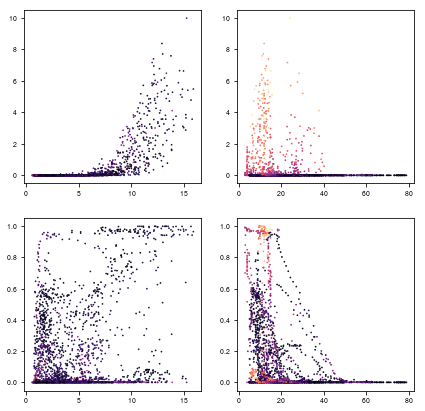

In [34]:


plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 0.5

LW=0.8

fs = 7

fig = plt.gcf()

ax1 = plt.subplot(221)

s = ax1.scatter(xxx3, yyy1, s=S,c=zzz1,cmap='magma')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(222)

s = ax1.scatter(zzz1, yyy1, s=S,c=xxx3,cmap='magma')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(223)

s = ax1.scatter(xxx3, yyy2, s=S,c=zzz1,cmap='magma')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(224)

s = ax1.scatter(zzz1, yyy2, s=S,c=xxx3,cmap='magma')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.set_size_inches(7, 7, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name52.pdf', bbox_inches='tight')

/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10
/home/andrew/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10


/home/andrew/Documents


/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


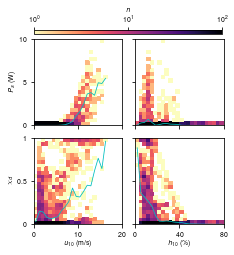

In [35]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

v1=0
v2=2

LW=0.8
LC='c'

fs = 7

fig = plt.gcf()

ax1 = plt.subplot(221)

counts, _, _ = np.histogram2d(xxx3, yyy1, bins=(xxx3bins, yyy1bins))

sc1 = ax1.pcolormesh(xxx3bins, yyy1bins, np.log10(counts).T,cmap='magma_r',vmin=v1,vmax=v2)
s = ax1.plot(xxx3av_xxx3bins, yyy1av_xxx3bins,lw=LW,c=LC)

plt.ylim([yyy1l,yyy1h])
plt.xlim([xxx3l,xxx3h])

ax1.set_xticks([0,10,20])
ax1.set_xticklabels(['','',''],fontsize=fs)
ax1.set_yticks([0,5,10])
ax1.set_yticklabels(['$0$','$5$','$10$'],fontsize=fs)

ax1.set_ylabel('$P_{s}$ (W)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(222)

counts, _, _ = np.histogram2d(zzz1, yyy1, bins=(zzz1bins, yyy1bins))

sc1 = ax1.pcolormesh(zzz1bins, yyy1bins, np.log10(counts).T,cmap='magma_r',vmin=v1,vmax=v2)
s = ax1.plot(zzz1av_zzz1bins, yyy1av_zzz1bins,lw=LW,c=LC)

plt.ylim([yyy1l,yyy1h])
plt.xlim([zzz1l,zzz1h])

ax1.set_xticks([0,40,80])
ax1.set_xticklabels(['','',''],fontsize=fs)
ax1.set_yticks([0,5,10])
ax1.set_yticklabels(['','',''],fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(223)

counts, _, _ = np.histogram2d(xxx3, yyy2, bins=(xxx3bins, yyy2bins))

sc1 = ax1.pcolormesh(xxx3bins, yyy2bins, np.log10(counts).T,cmap='magma_r',vmin=v1,vmax=v2)
s = ax1.plot(xxx3av_xxx3bins, yyy2av_xxx3bins,lw=LW,c=LC)

plt.ylim([yyy2l,yyy2h])
plt.xlim([xxx3l,xxx3h])

ax1.set_xticks([0,10,20])
ax1.set_xticklabels(['$0$','$10$','$20$'],fontsize=fs)
ax1.set_yticks([0,0.5,1])
ax1.set_yticklabels(['$0$','$0.5$','$1$'],fontsize=fs)

ax1.set_xlabel('$u_{10}$ (m/s)', fontsize=fs)
ax1.set_ylabel('$\\chi_{d}$', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(224)

counts, _, _ = np.histogram2d(zzz1, yyy2, bins=(zzz1bins, yyy2bins))

sc1 = ax1.pcolormesh(zzz1bins, yyy2bins, np.log10(counts).T,cmap='magma_r',vmin=v1,vmax=v2)
s = ax1.plot(zzz1av_zzz1bins, yyy2av_zzz1bins,lw=LW,c=LC)

plt.ylim([yyy2l,yyy2h])
plt.xlim([zzz1l,zzz1h])

ax1.set_xticks([0,40,80])
ax1.set_xticklabels(['$0$','$40$','$80$'],fontsize=fs)
ax1.set_yticks([0,0.5,1])
ax1.set_yticklabels(['','',''],fontsize=fs)

ax1.set_xlabel('$h_{10}$ (\%)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

cbar2_ax = fig.add_axes([0.125, 0.90, 0.77, 0.02])

cbar2 = fig.colorbar(sc1, ticks=[0,1,2,3,4,5], cax=cbar2_ax, orientation='horizontal')
cbar2.ax.set_xticklabels(['$10^{0}$', '$10^{1}$', '$10^{2}$', '$10^{3}$', '$10^{4}$', '$10^{5}$'])
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.set_label('$n$',fontsize=fs)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(labelsize=fs)

fig.subplots_adjust(hspace=.15)
fig.subplots_adjust(wspace=.15)

fig.set_size_inches(3.4, 3.4, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name62.pdf', bbox_inches='tight')

In [36]:
smooth_timescale = 60*60

#####

traj_smoothgl = boxcar_width(smooth_timescale*np.shape(tgd_l)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

temp1 = tgd_l%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)

temp2 = dTdzfit[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

gammagl_l_daytd = temp1
gammagl_l_daytt = tgl_traj
gammagl_l_dayav = temp3
gammagl_l_day25 = temp41
gammagl_l_day75 = temp42

#####

traj_smoothgl = boxcar_width(smooth_timescale*np.shape(tgd_l)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

temp1 = tgd_l%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)

temp2 = u0gl_c[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

u0gl_c_daytd = temp1
u0gl_c_daytt = tgl_traj
u0gl_c_dayav = temp3
u0gl_c_day25 = temp41
u0gl_c_day75 = temp42

#####

traj_smoothgl = boxcar_width(smooth_timescale*np.shape(tgd_l)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

temp1 = tgd_l%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)

temp2 = hgl_m[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

hgl_m_daytd = temp1
hgl_m_daytt = tgl_traj
hgl_m_dayav = temp3
hgl_m_day25 = temp41
hgl_m_day75 = temp42

#####

traj_smoothgl = boxcar_width(smooth_timescale*np.shape(tgd_l)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

temp1 = tgd_l%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)

temp2 = u11g_l[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

u11g_l_daytd = temp1
u11g_l_daytt = tgl_traj
u11g_l_dayav = temp3
u11g_l_day25 = temp41
u11g_l_day75 = temp42

#####

traj_smoothgl = boxcar_width(smooth_timescale*np.shape(td_g)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

temp1 = td_g%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)

temp2 = pd_g[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

pd_g_daytd = temp1
pd_g_daytt = tgl_traj
pd_g_dayav = temp3
pd_g_day25 = temp41
pd_g_day75 = temp42

#####

traj_smoothgl = boxcar_width(smooth_timescale*np.shape(tgd_l)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

temp1 = tgd_l%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)

temp2 = KEgl_s[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

KEgl_s_daytd = temp1
KEgl_s_daytt = tgl_traj
KEgl_s_dayav = temp3
KEgl_s_day25 = temp41
KEgl_s_day75 = temp42

In [37]:
traj_smoothgl = boxcar_width(smooth_timescale*np.shape(tgd_l)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

temp1 = tgd_l%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)

temp2 = pdgl_g[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

pdgl_g_daytd = temp1
pdgl_g_daytt = tgl_traj
pdgl_g_dayav = temp3
pdgl_g_day25 = temp41
pdgl_g_day75 = temp42


/home/andrew/Documents


/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


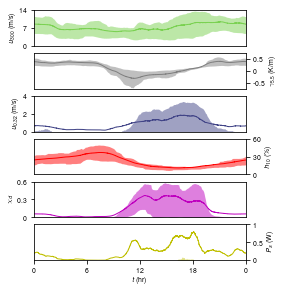

In [38]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 0.5

LW=1

fs = 7

cmap = plt.cm.get_cmap('viridis')
c1 = cmap(0.2)
c3 = cmap(0.8)

fig = plt.gcf()

ax1 = plt.subplot(611)

s = ax1.plot(u11g_l_daytt, u11g_l_dayav, lw=LW,c=c3)

f = ax1.fill_between(u11g_l_daytt, u11g_l_day25, u11g_l_day75, color=c3, alpha=0.5, linewidth=0)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([0,1])
plt.ylim([0,14])

plt.ylabel('$u_{300}$ (m/s)', fontsize=fs)

plt.xticks([],[])
plt.yticks(np.linspace(0,14,3), ('0', '7', '14'))

ax1 = plt.subplot(612)

s = ax1.plot(gammagl_l_daytt, gammagl_l_dayav, lw=LW,c='grey')

f = ax1.fill_between(gammagl_l_daytt, gammagl_l_day25, gammagl_l_day75, color='grey', alpha=0.5, linewidth=0)

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([0,1])
plt.ylim([-0.75,0.75])

plt.ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.xticks([],[])
plt.yticks(np.linspace(-0.5,0.5,3), ('-0.5', '0', '0.5'))

ax1 = plt.subplot(613)

s = ax1.plot(u0gl_c_daytt, u0gl_c_dayav, lw=LW,c=c1)

f = ax1.fill_between(u0gl_c_daytt, u0gl_c_day25, u0gl_c_day75, color=c1, alpha=0.5, linewidth=0)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([0,1])
plt.ylim([0,4])

plt.ylabel('$u_{0.32}$ (m/s)', fontsize=fs)

plt.xticks([],[])
plt.yticks(np.linspace(0,4,3), ('0', '2', '4'))

ax1 = plt.subplot(614)

s = ax1.plot(hgl_m_daytt, hgl_m_dayav, lw=LW,c='r')

f = ax1.fill_between(hgl_m_daytt, hgl_m_day25, hgl_m_day75, color='r', alpha=0.5, linewidth=0)

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([0,1])
plt.ylim([0,60])

plt.ylabel('$h_{10}$ (\%)', fontsize=fs)

plt.xticks([],[])
plt.yticks(np.linspace(0,60,3), ('0', '30', '60'))

ax1 = plt.subplot(615)

s = ax1.plot(pdgl_g_daytt, pdgl_g_dayav, lw=LW,c='m')

f = ax1.fill_between(pdgl_g_daytt, pdgl_g_day25, pdgl_g_day75, color='m', alpha=0.5, linewidth=0)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([0,1])
plt.ylim([0,0.6])

plt.ylabel('$\\chi_d$', fontsize=fs)

plt.xticks([],[])
plt.yticks(np.linspace(0,0.6,3), ('0', '0.3', '0.6'))

ax1 = plt.subplot(616)

s = ax1.plot(KEgl_s_daytt, KEgl_s_dayav, lw=LW,c='y')

f = ax1.fill_between(KEgl_s_daytt, KEgl_s_day25, KEgl_s_day75, color='y', alpha=0.5, linewidth=0)

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([0,1])
plt.ylim([0,1])

plt.ylabel('$P_s$ (W)', fontsize=fs)
plt.xlabel('$t$ (hr)', fontsize=fs)

plt.xticks(np.linspace(0,1,5), ('0', '6', '12', '18', '0'))
plt.yticks(np.linspace(0,1,3), ('0', '0.5', '1'))

fig.set_size_inches(3.8,4.6, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name63.pdf', bbox_inches='tight')

/home/andrew/Documents


/home/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


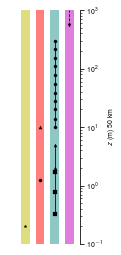

In [39]:
from matplotlib.patches import Rectangle

cmap = plt.cm.get_cmap('viridis')

cu = cmap(0.5)
ca = 'r'
cs = 'y'
cr = 'm'

C = 'k'
S = 10
fs = 7
LW = 0.8
lws = 0.25
A = 0.5

zul = z_l[1:]
zum = [2,5]
zuc = [0.32,0.76,1.68]
zal = 1.26
zam = 10
zss = (0.07874+0.325)/2
zrg = 550

xul = np.zeros_like(zul)+0.05
xum = np.zeros_like(zum)+0.05
xuc = np.zeros_like(zuc)+0.05
xal = 0+0.03
xam = 0+0.03
xss = 0+0.01
xrg = 0+0.07

uxy = [0.044,0.1]
axy = [0.024,0.1]
sxy = [0.004,0.1]
rxy = [0.064,0.1]

uw = 0.012
aw = 0.012
sw = 0.012
rw = 0.012

h = 1000-0.01

ur = patches.Rectangle(uxy,uw,h,linewidth=0,edgecolor='none',facecolor=cu,alpha=A,zorder=-1)
ar = patches.Rectangle(axy,aw,h,linewidth=0,edgecolor='none',facecolor=ca,alpha=A,zorder=-1)
sr = patches.Rectangle(sxy,sw,h,linewidth=0,edgecolor='none',facecolor=cs,alpha=A,zorder=-1)
rr = patches.Rectangle(rxy,rw,h,linewidth=0,edgecolor='none',facecolor=cr,alpha=A,zorder=-1)

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

ax = plt.subplot(111)

s = ax.add_patch(ur)
s = ax.add_patch(ar)
s = ax.add_patch(sr)
s = ax.add_patch(rr)

s = ax.plot(xul,zul,c=C,lw=LW)
s = ax.plot(xum,zum,c=C,lw=LW)
s = ax.plot(xuc,zuc,c=C,lw=LW)
s = ax.plot([xrg,xrg],[zrg,1000],'--',c=C,lw=LW)

s = ax.scatter(xul,zul,marker='o',c=C,s=S,linewidth=lws)
s = ax.scatter(xum,zum,marker='^',c=C,s=S,linewidth=lws)
s = ax.scatter(xuc,zuc,marker='s',c=C,s=S,linewidth=lws)

s = ax.scatter(xal,zal,marker='o',c=C,s=S,linewidth=lws)
s = ax.scatter(xam,zam,marker='^',c=C,s=S,linewidth=lws)
s = ax.scatter(xss,zss,marker='*',c=C,s=S,linewidth=lws)
s = ax.scatter(xrg,zrg,marker='v',c=C,s=S,linewidth=lws)

plt.ylabel('$z$ (m) 50 km', fontsize=fs)

plt.xlim([-0.01,0.085])
plt.ylim([0.1,1000])

ax.set_yscale('log')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

plt.xticks([],[])
plt.yticks(fontsize=fs)

# ax.legend(loc=0,frameon=False,fontsize=fs)

fig = plt.gcf()
fig.set_size_inches(1.25, 4.3, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name13.pdf', bbox_inches='tight')

In [ ]:
#  WIND SPEED MEASUREMENT HEIGHTS IN THE FOLLOWING PAPERS 
# 
#  1 Tsoar (1983)
#  2 Nickling, Gillies (1993)
#  3 Arens (1994)
#  4 Frank, Kocurek (1994)
#  5 Gillette, Herbert, Stockton, Owen (1996)
#  6 Greeley, Blumberg, Williams (1996)
#  7 Jackson McCloskey (1997)
#  8 Stout, Zobeck (1997)
#  9 Sterk, Van Boxel (1998)
# 10 Gomes, Arrue, Lopez, Sterk, Richard, Gracia, Sabre, Gaudichet, Frangi (2003)
# 11 Namikas (2003)
# 12 Wiggs, Baird, Atherton (2003)
# 13 Baas, Sherman (2005)
# 14 Baas (2006)
# 15 McKenna-Neuman, Lancaster, Nickling (2006)
# 16 Davidson-Arnott, Yang, Ollerhead, Hesp, Walker (2007)
# 17 Ishizuka, Mikami, Leys, Yamada, Heidenreich, Shao, McTainish (2008)
# 18 Sow, Alfaro, Rajot, Marticorena (2009)
# 19 Li, Sherman, Farrell, Ellis (2010)
# 20 Jerolmack, Reitz, Martin (2011)
# 21 Bauer, Davidson-Arnott, Alker, Hesp, Ollerhead (2012)
# 22 Dong, Lv, Zhang, Qian, Luo (2012)
# 23 Pfeifer, Shconfeldt (2012)
# 24 Wiggs, Weaver (2012)
# 25 Barrineau, Ellis (2013)
# 26 Chapman, Walker, Hesp, Bauer, Davidson-Arnott, Ollerhead (2013)
# 27 Martin, Barchyn, Hugenholtz, Jerolmack (2013)
# 28 Poortinga, Keijsers, Visser, Riksen, Baas (2014)
# 29 Lanigan, Stout, Anderson (2016)
# 30 Webb, Galloza, Zobeck, Herrick (2016)
# 31 Dupont, Rajot, Labiadh, Bergametti, Alfaro, Bouet, Fernandes, Khalfallah, Lamaud, Marticorena, Bonnefond, Chevaillier, Garrigou, Henry-des-Tureaux, Sekrafi, Zapf (2018)
# 32 Martin, Kok, Hugenholtz, Barchyn, Chamecki, Ellis (2018)


H1 = 0.16
H2 = [0.5,1,2,3.5,6,10]
H3 = 5
H4 = [0.5,1,2,3,4,5]
H5 = [0.2,0.5,1,3]
H6 = [0.75,1.25,2.07,3.44,5.72,9.5]
H7 = 0.6
H8 = 2
H9 = 3
H10 = [0.2,0.4,1,2,4]
H11 = [0.1,0.2,0.3,0.5,0.8,1.4,2,2.5]
H12 = [0.1,0.15,0.25]
H13 = [0.1,0.35,0.6,0.85,1.1]
H14 = 0.04
H15 = 0.3
H16 = [2.15,0.3,0.5,1.1,0.3,2.3]
H17 = [0.5,2.16]
H18 = [0.35,0.8,1.5,2.32,4.75,0.59,1.27,2.11,4.48]
H19 = [0.25,0.5,0.75,1]
H20 = 10
H21 = [0.2,0.45,0.7,1.1,1.75,3.815,3.64]
H22 = [1,2,4,8,16,24,32,48]
H23 = [0.115,0.185,0.145,0.2,2]
H24 = 2.2
H25 = 1
H26 = [0.2,1.2]
H27 = 0.49
H28 = [0.2,0.5,0.8,2]
H29 = 2
H30 = [0.7,1.4,2.4,4.8]
H31 = [0.2,0.6,1.3,1.8,3,4,5.2]
H32 = [0.43,0.45,0.47,0.48,0.64,0.97,0.98,1,1.16,1.76,1.79,1.8,1.93,2.07,2.58,2.59,2.75,2.81,3.02,3.05,6,8.95]

H = [H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24,H25,H26,H27,H28,H29,H30,H31,H32]
H0 = [0.32,0.76,1.68,2,5,10,14,20,28,38,55,78,109,153,214,300]

In [ ]:
cmap = plt.cm.get_cmap('gist_ncar')

z_l = np.asarray([1.26,10,14,20,28,38,55,78,109,153,214,300])
zul = z_l[1:]
zum = [2,5]
zuc = [0.32,0.76,1.68]
zss = (0.07874+0.325)/2

S = 10
fs = 7
lws = 0.25
A = 0.5

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

ax = plt.subplot(111)

# for i in np.arange(0,32):
#     s = ax.scatter(np.ones_like(H[i])*i,H[i],marker='o',c='none',edgecolors=cmap(i/32),s=S,linewidth=lws)

# # s = ax.scatter(np.ones_like(H0)*35,H0,marker='o',c='k',edgecolors='k',s=S,linewidth=lws)

# s = ax.scatter(np.ones_like(zul)*35,zul,marker='o',c='k',s=S-3,linewidth=0)
# s = ax.scatter(np.ones_like(zum)*35,zum,marker='^',c='k',s=S-3,linewidth=0)
# s = ax.scatter(np.ones_like(zuc)*35,zuc,marker='s',c='k',s=S-3,linewidth=0)
# s = ax.scatter(np.ones_like(zss)*35,zss,marker='*',c='k',s=S+3,linewidth=0)

s = ax.scatter([35, 35],[1,10],marker='o',c='r',s=20,linewidth=0)

plt.ylabel('$z$ (m)', fontsize=fs)

plt.ylim([0,11])

plt.xlim([-1,40])



ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

plt.xticks([],[])
plt.yticks(fontsize=fs)

fig = plt.gcf()
fig.set_size_inches(1.25, 3.3, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name67.png', bbox_inches='tight',dpi=300)

In [ ]:
theta = 300
g = 9.81
zed = 0.32
zed0 = 0.1

def phi(zeta):
    if zeta>=0:
        x = 1+5*zeta
    else:
        x = (1-16*zeta)**-0.25
    return x

def PHI(zeta):
    if zeta>=0:
        x = -5*zeta
    else:
        y = (1-16*zeta)**0.25
        x = 2*np.log((1+y)/2)+np.log((1+y**2)/2)-2*np.arctan(y)+np.pi/2
    return x

def fun(zeta):
    if zeta>=0:
        x = zeta*(0.74+4.7*zeta)/(1+4.7*zeta)**2
    else:
        x = 0.74*zeta*((1-15*zeta)/(1-9*zeta))**0.5
    return x

zeta = np.linspace(-10,10,1000)
gamma = np.empty_like(zeta)
uratio = np.empty_like(zeta)

for i in np.arange(0,np.shape(zeta)[0]):
    gamma[i] = theta/g*(zed*(np.log(zed/zed0)-PHI(zeta[i]))/phi(zeta[i]))**2*fun(zeta[i])
    uratio[i] = np.log(zed/zed0)-PHI(zeta[i])

In [ ]:


plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 5

LW=0.8

fs = 7

fig = plt.gcf()

ax1 = plt.subplot(111)

s = ax1.plot(1/uratio, gamma)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlim([0,2])
plt.ylim([-1,1])

fig.set_size_inches(7, 7, forward=True)
# %cd /home/andrew/Documents/
# plt.savefig('some_name52.pdf', bbox_inches='tight')